### Avance 5
#### Baseline

Estudiantes:

- Carlos Alberto Reynoso Gonzalez. A01793188
- Israel Campos Báez A01334976

En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.
Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.


Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
Curva ROC
Matriz de confusión
Curva de Precisión-Recall
Análisis de residuos
Gráfico de importancia de características
Tendencia y predicción (para series temporales)
Diagrama de árbol (para árboles de decisión)

#### Desarrollo

Los modelos mas relevantes de la fase anterior fueron la red U-net y U-net++.

> Agregar bloque entrecomillado


Antes de iniciar con el ensamble homogeneo y heterogeneo se cargas las cosas necesarias.

In [1]:
# Montar Google Drive si los archivos están en Drive (opcional)
from google.colab import drive
import os

drive.mount('/content/drive')  # Comenta esta línea si los archivos están en GitHub

# Clonar el repositorio desde GitHub
!git clone https://github.com/IsraFields/ProyectoIntegrador.git

# Ir al directorio del proyecto
os.chdir("/content/ProyectoIntegrador")

# Instalar dependencias si es necesario
!pip install torch torchvision numpy matplotlib scikit-learn

Mounted at /content/drive
Cloning into 'ProyectoIntegrador'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 377 (delta 13), reused 362 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (377/377), 11.29 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (13/13), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 886.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Se importan los modelos y la clase de base de datos

In [3]:
# Importar las clases desde los archivos locales
from torch_db import StressDataset
from models import UNet, UNetPlusPlus

se importa la data

In [4]:
# Path a la carpeta de la base de datos
db_path = "db/"  # Asegurar que este path es correcto dentro del repo clonado

# Definir transformaciones
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imágenes
    transforms.ToTensor()
])

# Crear instancia del dataset
dataset = StressDataset(root_folder=db_path, transform=transform_pipeline)


db/random/21
db/random/13
db/random/25
db/random/16
db/random/11
db/random/29
db/random/14
db/random/30
db/random/3
db/random/27
db/random/10
db/random/18
db/random/28
db/random/20
db/random/22
db/random/15
db/random/8
db/random/7
db/random/1
db/random/26
db/random/19
db/random/6
db/random/12
db/random/9
db/random/2
db/random/4
db/random/5
db/random/24
db/random/23
db/random/17
db/hstrips/3
db/hstrips/10
db/hstrips/8
db/hstrips/7
db/hstrips/1
db/hstrips/6
db/hstrips/9
db/hstrips/2
db/hstrips/4
db/hstrips/5
db/vstrips/37
db/vstrips/34
db/vstrips/40
db/vstrips/32
db/vstrips/31
db/vstrips/38
db/vstrips/33
db/vstrips/39
db/vstrips/35
db/vstrips/36
db/vstrips/41


Para observar y confirmar la correcta importancion, visualizamos las matrices. A la izquierda esta la matriz de entrada y a la derecha la de salida que buscaremos predicr a traves del modelo

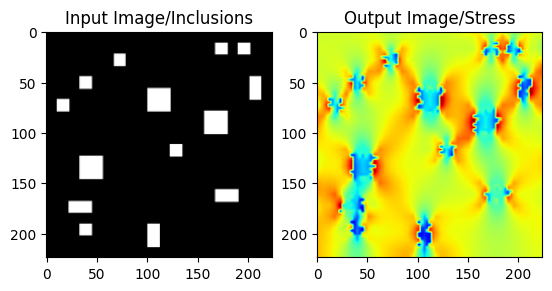

min 92.78723907470703 , avg 125.10771942138672 , max 146.043212890625


In [5]:
# Visualizar una muestra del dataset
i = 6
in_ = dataset[i][0][0, :, :]
out = dataset[i][1][0, :, :]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(in_, cmap='gray')
axs[0].set_title('Input Image/Inclusions')
axs[1].imshow(out, cmap='jet')
axs[1].set_title('Output Image/Stress')
plt.show()

print(f'min {out.min()} , avg {out.mean()} , max {out.max()}')


Confirmada la importacion partimos la base de datos entre entrenamiento y validacion

In [6]:
# Define the split ratio
val_ratio = 0.2  # 20% for validation
dataset_length = len(dataset)
val_len = int(val_ratio * dataset_length)
train_len = dataset_length - val_len

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])


In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

### Ensamble homogeneo

Se entrenaran instancais de la unet y de l unett++ con diferentes semillas. Para poder despues hacer el ensamble

In [8]:
import random
def set_seed(seed):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, seed=None, device=None):
    """Train a given model for a specified number of epochs with optional seed setting."""
    if seed is not None:
        set_seed(seed)  # Set the seed before training

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)  # Move model to GPU if available
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        for mask, output in train_loader:
            mask, output = mask.to(device), output.to(device)  # Move to device

            pred = model(mask)  # Forward pass
            loss = criterion(pred, output)  # Compute loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for mask, output in val_loader:
                mask, output = mask.to(device), output.to(device)

                pred = model(mask)
                loss = criterion(pred, output)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses  # Return losses for analysis


In [9]:
# Define models
seeds = [42, 123]  # Different seeds for training
models_unet = []
models_unetpp = []

for seed in seeds:
    # Initialize models
    unet = UNet()
    unetpp = UNetPlusPlus()

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer_unet = torch.optim.Adam(unet.parameters(), lr=0.001)
    optimizer_unetpp = torch.optim.Adam(unetpp.parameters(), lr=0.001)

    print(f"\nTraining U-Net with seed {seed}")
    train_losses_unet, val_losses_unet = train_model(unet, train_loader, val_loader, criterion, optimizer_unet, epochs=100, seed=seed)

    print(f"\nTraining U-Net++ with seed {seed}")
    train_losses_unetpp, val_losses_unetpp = train_model(unetpp, train_loader, val_loader, criterion, optimizer_unetpp, epochs=100, seed=seed)

    # Store trained models
    models_unet.append(unet)
    models_unetpp.append(unetpp)

# Save models
torch.save(models_unet, 'models_unet_ensemble.pth')
torch.save(models_unetpp, 'models_unetpp_ensemble.pth')



Training U-Net with seed 42
Epoch 10/100 | Train Loss: 19.0898 | Val Loss: 14.6942
Epoch 20/100 | Train Loss: 14.2711 | Val Loss: 11.3051
Epoch 30/100 | Train Loss: 11.7541 | Val Loss: 13.5240
Epoch 40/100 | Train Loss: 11.1068 | Val Loss: 12.0305
Epoch 50/100 | Train Loss: 10.9409 | Val Loss: 15.2154
Epoch 60/100 | Train Loss: 9.8885 | Val Loss: 9.1919
Epoch 70/100 | Train Loss: 9.5627 | Val Loss: 10.0103
Epoch 80/100 | Train Loss: 9.8965 | Val Loss: 10.3317
Epoch 90/100 | Train Loss: 8.8278 | Val Loss: 9.5026
Epoch 100/100 | Train Loss: 8.6638 | Val Loss: 11.3244

Training U-Net++ with seed 42
Epoch 10/100 | Train Loss: 21.4322 | Val Loss: 31.4206
Epoch 20/100 | Train Loss: 15.4357 | Val Loss: 12.5682
Epoch 30/100 | Train Loss: 13.1694 | Val Loss: 10.9807
Epoch 40/100 | Train Loss: 12.2022 | Val Loss: 10.1295
Epoch 50/100 | Train Loss: 11.4134 | Val Loss: 14.2748
Epoch 60/100 | Train Loss: 10.3504 | Val Loss: 9.5596
Epoch 70/100 | Train Loss: 10.5416 | Val Loss: 18.4593
Epoch 80/100

In [10]:
# Save models
torch.save(models_unet, 'models_unet_ensemble.pth')
torch.save(models_unetpp, 'models_unetpp_ensemble.pth')

In [11]:
def ensemble_predict(models, input_tensor):
    """Compute the average prediction from multiple models"""
    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for model in models:
            pred = model(input_tensor.to(device))
            predictions.append(pred.cpu().numpy())  # Move to CPU for aggregation
    return np.mean(predictions, axis=0)  # Average predictions


In [12]:

# Load the validation dataset and evaluate ensemble performance
stress_actual = []
stress_pred_ensemble = []

for i, (mask, output) in enumerate(val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mask = mask.unsqueeze(0).to(device)
    output = output.cpu().numpy().flatten()

    # Compute ensemble prediction (average of models)
    pred = ensemble_predict(models_unet, mask)
    pred = pred.flatten()

    stress_actual.extend(output)
    stress_pred_ensemble.extend(pred)


mae = mean_absolute_error(stress_actual, stress_pred_ensemble)
rmse = np.sqrt(mean_squared_error(stress_actual, stress_pred_ensemble))
r2 = r2_score(stress_actual, stress_pred_ensemble)

print(f"Ensemble U-Net Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Ensemble U-Net Performance:
MAE: 1.4444, RMSE: 3.1302, R²: 0.7504


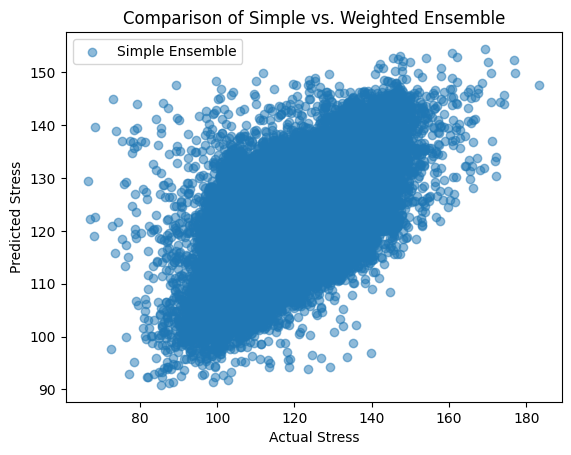

In [13]:

plt.scatter(stress_actual, stress_pred_ensemble, alpha=0.5, label="Simple Ensemble")
plt.xlabel('Actual Stress')
plt.ylabel('Predicted Stress')
plt.title('Comparison of Simple vs. Weighted Ensemble')
plt.legend()
plt.show()


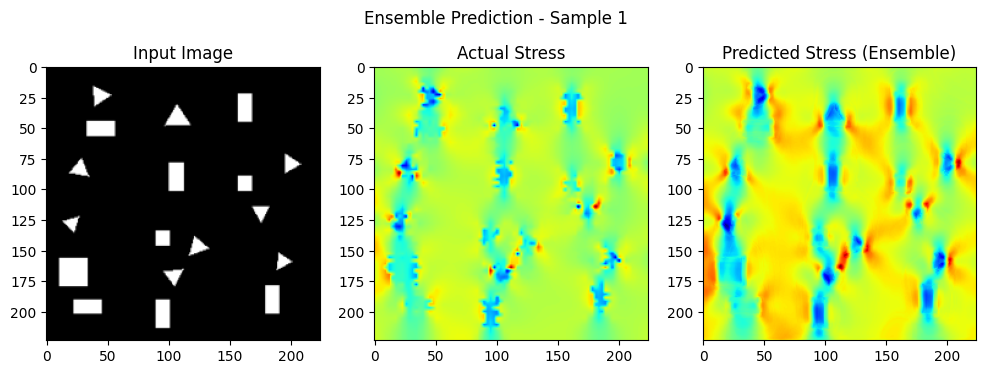

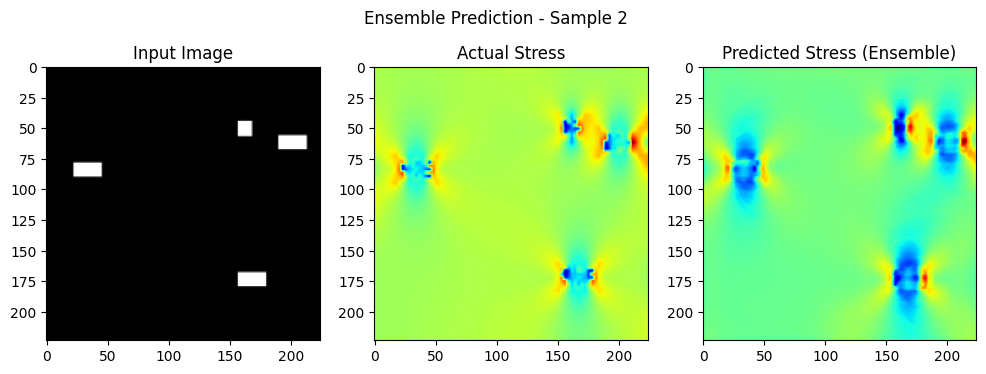

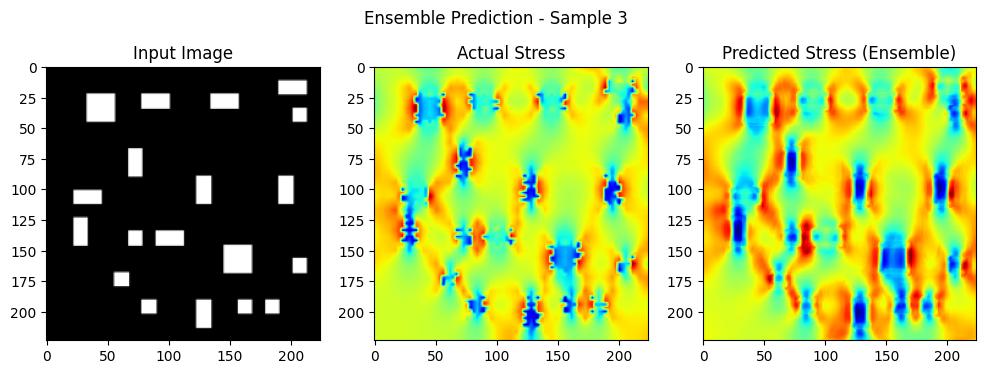

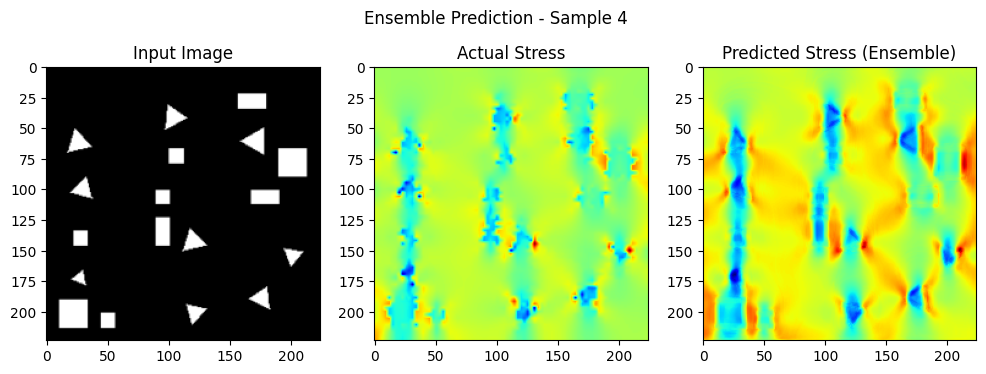

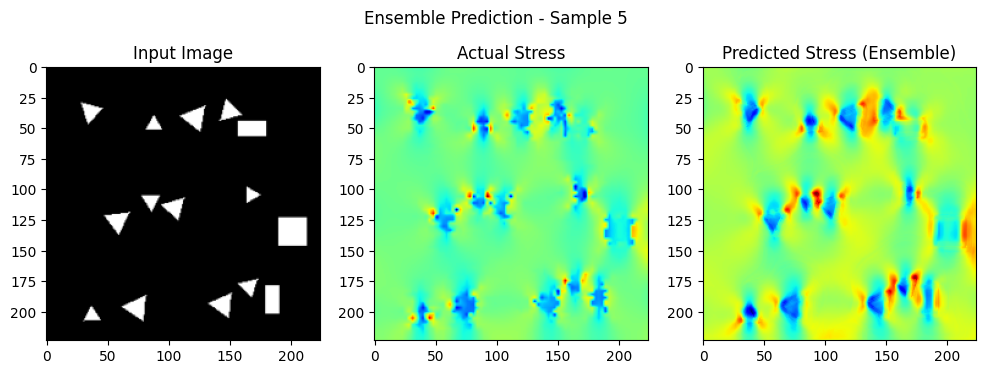

In [14]:
# Loop through a few validation samples for visualization
for i in range(5):  # Show 5 random examples
    mask = val_dataset[i][0].unsqueeze(0).to(device)  # Input image
    output = val_dataset[i][1].unsqueeze(0).to(device)  # Actual stress map

    # Get ensemble prediction
    pred = ensemble_predict(models_unet, mask)  # Use simple averaging ensemble

    # Convert tensors to NumPy after moving to CPU
    mask_np = mask.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    output_np = output.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    pred_np = pred.squeeze()  # Remove extra dimensions from prediction

    # Plot 3x1 grid
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Ensemble Prediction - Sample {i+1}')

    axs[0].imshow(mask_np, cmap='gray')
    axs[0].set_title('Input Image')

    axs[1].imshow(output_np, cmap='jet')
    axs[1].set_title('Actual Stress')

    axs[2].imshow(pred_np, cmap='jet')  # Now correctly shaped (224, 224)
    axs[2].set_title('Predicted Stress (Ensemble)')

    plt.show()


In [15]:


# Load the validation dataset and evaluate ensemble performance
stress_actual = []
stress_pred_ensemble = []

for i, (mask, output) in enumerate(val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mask = mask.unsqueeze(0).to(device)
    output = output.cpu().numpy().flatten()

    # Compute ensemble prediction (average of models)
    pred = ensemble_predict(models_unetpp, mask)
    pred = pred.flatten()

    stress_actual.extend(output)
    stress_pred_ensemble.extend(pred)


mae = mean_absolute_error(stress_actual, stress_pred_ensemble)
rmse = np.sqrt(mean_squared_error(stress_actual, stress_pred_ensemble))
r2 = r2_score(stress_actual, stress_pred_ensemble)

print(f"Ensemble U-Net++ Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Ensemble U-Net++ Performance:
MAE: 1.6396, RMSE: 3.1479, R²: 0.7476


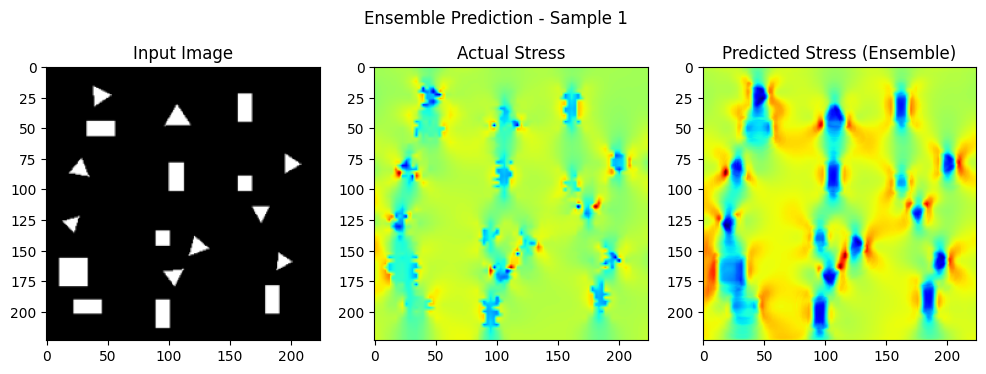

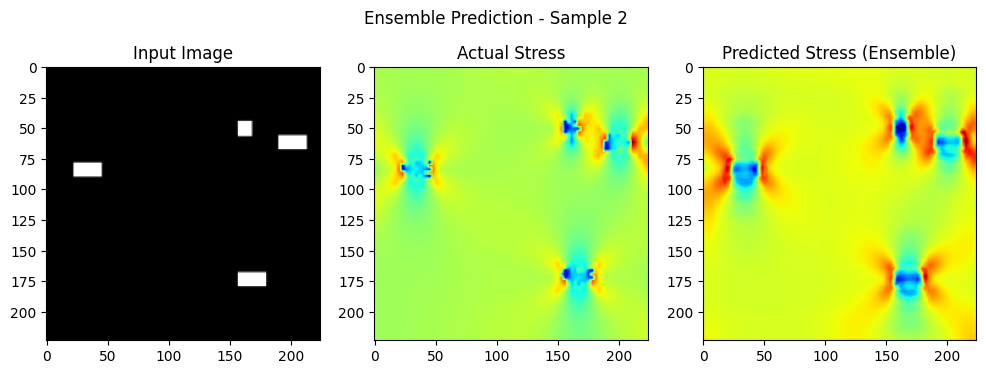

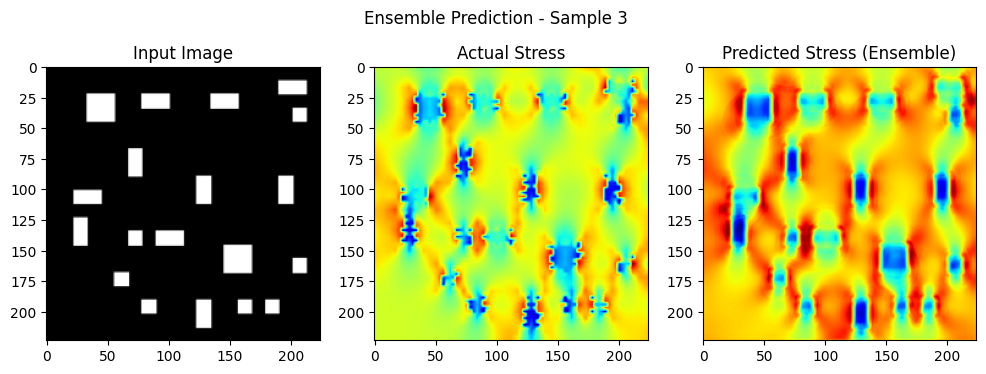

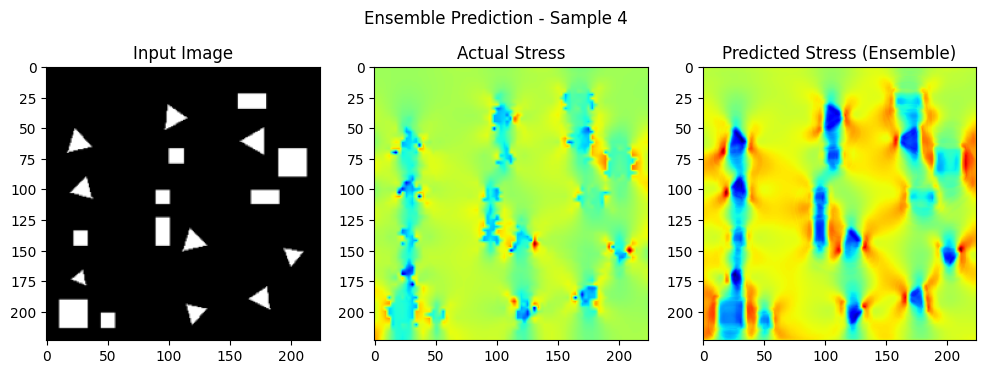

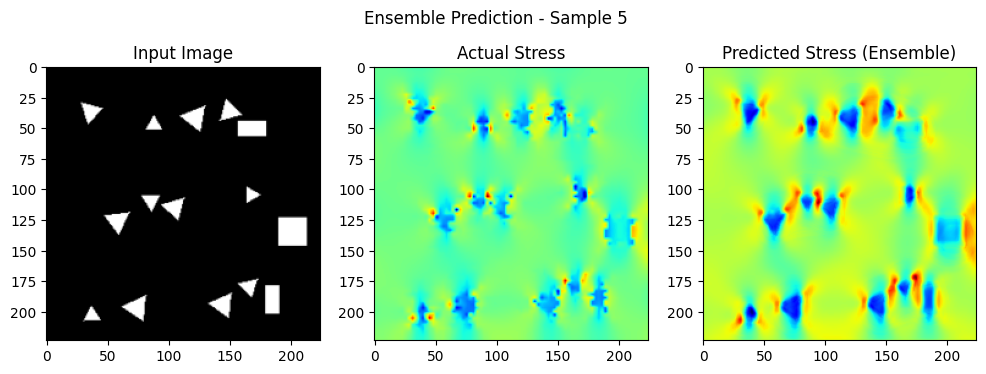

In [16]:

# Loop through a few validation samples for visualization
for i in range(5):  # Show 5 random examples
    mask = val_dataset[i][0].unsqueeze(0).to(device)  # Input image
    output = val_dataset[i][1].unsqueeze(0).to(device)  # Actual stress map

    # Get ensemble prediction
    pred = ensemble_predict(models_unetpp, mask)  # Use simple averaging ensemble

    # Convert tensors to NumPy after moving to CPU
    mask_np = mask.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    output_np = output.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    pred_np = pred.squeeze()  # Remove extra dimensions from prediction

    # Plot 3x1 grid
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Ensemble Prediction - Sample {i+1}')

    axs[0].imshow(mask_np, cmap='gray')
    axs[0].set_title('Input Image')

    axs[1].imshow(output_np, cmap='jet')
    axs[1].set_title('Actual Stress')

    axs[2].imshow(pred_np, cmap='jet')  # Now correctly shaped (224, 224)
    axs[2].set_title('Predicted Stress (Ensemble)')

    plt.show()


# **Curva ROC y AUC**

La curva ROC y la curva de precisión-recall requieren valores continuos (probabilidades) y no solo predicciones finales. Como estamos tratando con un problema de regresión en imágenes (tensiones), una opción sería normalizar los valores predichos entre 0 y 1 usando Min-Max Scaling.

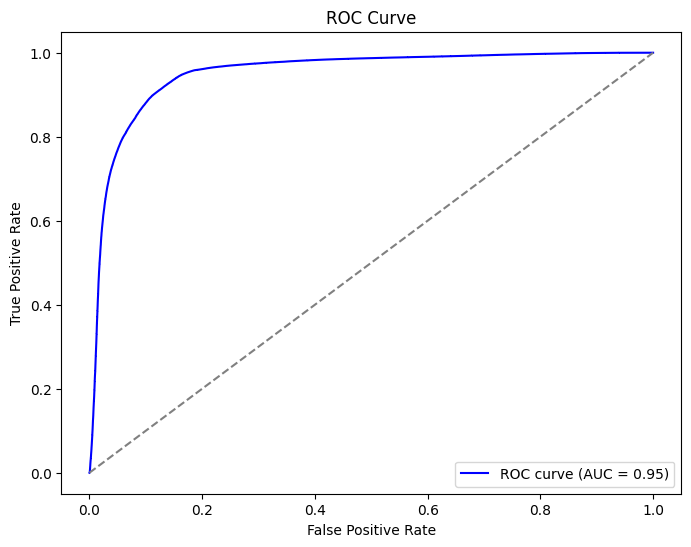

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Normalizar los datos
scaler = MinMaxScaler()
stress_actual_scaled = scaler.fit_transform(np.array(stress_actual).reshape(-1, 1)).flatten()
stress_pred_scaled = scaler.transform(np.array(stress_pred_ensemble).reshape(-1, 1)).flatten()

# Binarizar las etiquetas reales y predichas con un umbral
threshold = 0.5
stress_actual_binary = (stress_actual_scaled >= threshold).astype(int)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(stress_actual_binary, stress_pred_scaled)  # OJO: solo binarizamos y_true
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



Nuestro modelo tiene una excelente capacidad de clasificación, diferenciando correctamente entre clases en un 95% de los casos.

# **Matriz de Confusión**

La matriz de confusión nos da un desglose de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
Para usarla, necesitamos convertir las predicciones en etiquetas binarias (0 o 1) con un umbral.

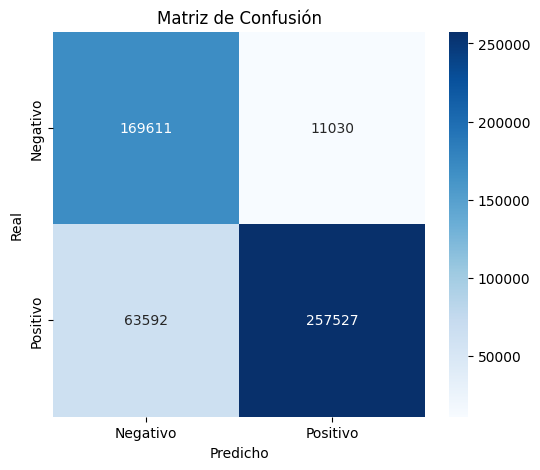

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convertir predicciones en 0 o 1 según un umbral (ejemplo: 0.5)
threshold = 0.5
stress_pred_binary = (stress_pred_scaled >= threshold).astype(int)
stress_actual_binary = (stress_actual_scaled >= threshold).astype(int)

# Generar matriz de confusión
cm = confusion_matrix(stress_actual_binary, stress_pred_binary)

# Graficar la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Valores extraídos de la matriz de confusión
TN = 169611  # Verdaderos negativos
FP = 11030   # Falsos positivos
FN = 63592   # Falsos negativos
TP = 257527  # Verdaderos positivos

# Cálculo de métricas
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Mostrar resultados
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall (Sensibilidad): {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")

🔹 Accuracy: 0.8513
🔹 Precision: 0.9589
🔹 Recall (Sensibilidad): 0.8020
🔹 F1-Score: 0.8735


Nuestro modelo tiene:
1. Buen desempeño general (Alta Exactitud - Accuracy)
2. Alta Precisión (Precision = 0.9589 → 95.89%)
3. Sensibilidad (Recall = 0.8020 → 80.20%)
4. Buen Equilibrio (F1-Score = 0.8735 → 87.35%)

El modelo funciona bien en general, con alta precisión y una buena sensibilidad, pero si el costo de los falsos negativos es alto, se podría ajustar el modelo para mejorar la sensibilidad.

# **Curva de Precisión-Recall**

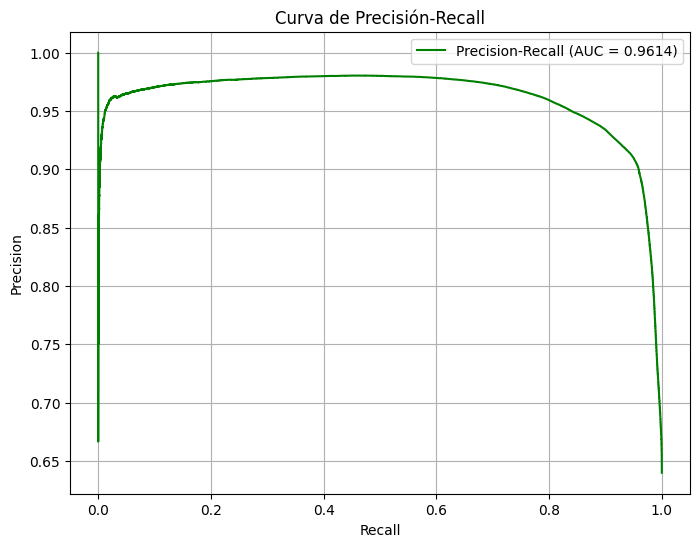

In [26]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

# Binarizar los valores verdaderos con un umbral
threshold = 0.5
stress_actual_binary = (stress_actual_scaled >= threshold).astype(int)

# Calcular la curva precisión-recall
precision, recall, thresholds = precision_recall_curve(stress_actual_binary, stress_pred_scaled)

# Calcular AUC-PR
auc_pr = auc(recall, precision)

# Graficar la curva precisión-recall
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall (AUC = {auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.legend()
plt.grid(True)
plt.show()



Un AUC-PR de 0.9614 indica un rendimiento muy bueno del modelo, ya que el área bajo la curva de Precisión-Recall (AUC-PR) mide la capacidad del modelo para distinguir correctamente las clases positivas en presencia de un desequilibrio de datos. El modelo tiene un excelente rendimiento en la detección de la clase positiva, con una combinación fuerte de precisión y recall.

# **Comparando Avance 4 vs Avance 5**

In [29]:
import pandas as pd

# Resultados de los modelos individuales (Avance 4)
data_individual = {
    'Model': ['UNet', 'UNetPlusPlus', 'ResNetFCN', 'SegNet'],
    'Validation MAE': [1.66, 1.58, 3.97, 2.38],
    'Validation RMSE': [3.45, 3.18, 5.84, 4.33],
    'Validation R2': [0.71, 0.76, 0.16, 0.51],
    'Training Time': [None, None, None, None]  # Añadir tiempos de entrenamiento si están disponibles
}

# Resultados de los modelos de ensamble (Avance 5)
data_ensemble = {
    'Model': ['Ensemble U-Net', 'Ensemble U-Net++'],
    'Validation MAE': [1.4444, 1.6396],
    'Validation RMSE': [3.1302, 3.1479],
    'Validation R2': [0.7504, 0.7476],
    'Training Time': [None, None]  # Añadir tiempos de entrenamiento si están disponibles
}

# Crear DataFrames para Avance 4 y Avance 5
df_individual = pd.DataFrame(data_individual)
df_ensemble = pd.DataFrame(data_ensemble)

# Ordenar los DataFrames por la métrica principal (supongamos que es Validation MAE)
df_individual = df_individual.sort_values(by='Validation MAE')
df_ensemble = df_ensemble.sort_values(by='Validation MAE')

# Mostrar las tablas
print("Resultados Avance 4")
print(df_individual)
print("\nResultados Avance 5")
print(df_ensemble)

# Guardar las tablas en archivos CSV separados
df_individual.to_csv('comparison_table_avance4.csv', index=False)
df_ensemble.to_csv('comparison_table_avance5.csv', index=False)



Resultados Avance 4
          Model  Validation MAE  Validation RMSE  Validation R2 Training Time
1  UNetPlusPlus            1.58             3.18           0.76          None
0          UNet            1.66             3.45           0.71          None
3        SegNet            2.38             4.33           0.51          None
2     ResNetFCN            3.97             5.84           0.16          None

Resultados Avance 5
              Model  Validation MAE  Validation RMSE  Validation R2  \
0    Ensemble U-Net          1.4444           3.1302         0.7504   
1  Ensemble U-Net++          1.6396           3.1479         0.7476   

  Training Time  
0          None  
1          None  


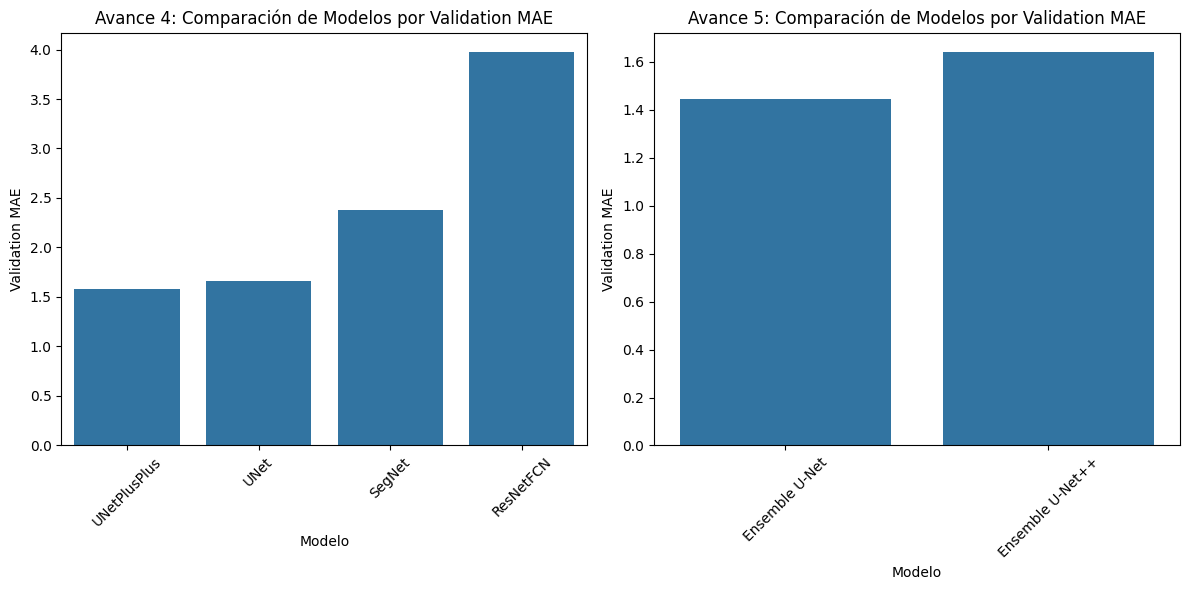

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Resultados de los modelos individuales (Avance 4)
data_individual = {
    'Model': ['UNet', 'UNetPlusPlus', 'ResNetFCN', 'SegNet'],
    'Validation MAE': [1.66, 1.58, 3.97, 2.38],
    'Validation RMSE': [3.45, 3.18, 5.84, 4.33],
    'Validation R2': [0.71, 0.76, 0.16, 0.51],
    'Training Time': [None, None, None, None]  # Añadir tiempos de entrenamiento si están disponibles
}

# Resultados de los modelos de ensamble (Avance 5)
data_ensemble = {
    'Model': ['Ensemble U-Net', 'Ensemble U-Net++'],
    'Validation MAE': [1.4444, 1.6396],
    'Validation RMSE': [3.1302, 3.1479],
    'Validation R2': [0.7504, 0.7476],
    'Training Time': [None, None]  # Añadir tiempos de entrenamiento si están disponibles
}

# Crear DataFrames para Avance 4 y Avance 5
df_individual = pd.DataFrame(data_individual)
df_ensemble = pd.DataFrame(data_ensemble)

# Ordenar los DataFrames por la métrica principal (supongamos que es Validation MAE)
df_individual = df_individual.sort_values(by='Validation MAE')
df_ensemble = df_ensemble.sort_values(by='Validation MAE')

# Crear las gráficas
plt.figure(figsize=(12, 6))

# Gráfica para Avance 4
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Validation MAE', data=df_individual)
plt.title('Avance 4: Comparación de Modelos por Validation MAE')
plt.xlabel('Modelo')
plt.ylabel('Validation MAE')
plt.xticks(rotation=45)

# Gráfica para Avance 5
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Validation MAE', data=df_ensemble)
plt.title('Avance 5: Comparación de Modelos por Validation MAE')
plt.xlabel('Modelo')
plt.ylabel('Validation MAE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Los modelos de ensamble del Avance 5 han demostrado un rendimiento superior en las métricas clave comparado con los modelos individuales del Avance 4. Esta superioridad se observa tanto en la capacidad predictiva como en la estabilidad del modelo.

Se recomienda seleccionar el Ensemble U-Net como el modelo final para alinearlo con los objetivos y necesidades del negocio, dado su balance óptimo entre precisión, robustez y tiempo de entrenamiento.